# Base code for R-GCN

In [3]:
# import packages and reading in files:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, RGCNConv
import torch.nn.functional as F
import matplotlib.pyplot as plt

# import python files needed to create adjacency matrices
import reading_data

In [7]:
# change up the code for R-GCN--> add a number in a tensor for everything instead of having multiple ones!!
adjacency_matrix, mapping_index_to_node, mapping_entity_to_index, map_index_to_relation = reading_data.create_adjacency_matrix_nt("data/aifb/aifb+.nt", literal_representation="filtered", sparse=True, relational=True)
number_nodes = adjacency_matrix.size()[0]

# add the file names
file_name_train = "data/aifb/gz_files/aifb+_train_set.nt.gz"
file_name_valid = "data/aifb/gz_files/aifb+_valid_set.nt.gz"
file_name_test = "data/aifb/gz_files/aifb+_test_set.nt.gz"

labels, train_entities, valid_entities, test_entities = reading_data.training_valid_test_set(file_name_train, file_name_valid, file_name_test, mapping_entity_to_index, adjacency_matrix.size()[0])
train_mask = torch.tensor([i in train_entities for i in range(len(labels))])
valid_mask = torch.tensor([i in valid_entities for i in range(len(labels))])
test_mask = torch.tensor([i in test_entities for i in range(len(labels))])

#feature_matrix = torch.sparse_coo_tensor(indices=torch.tensor([list(range(number_nodes)), list(range(number_nodes))]), values=torch.ones(number_nodes),size=(number_nodes, number_nodes))
feature_matrix = torch.rand(size=(number_nodes, 100)) # using 100 features

In [26]:
adjacency_matrix

tensor(indices=tensor([[ 157,  345,  853,  ..., 2488,  650, 1903],
                       [2492,  611,  676,  ..., 1418,  516,  526],
                       [  10,   18,    9,  ...,   13,    9,   13]]),
       values=tensor([1, 1, 1,  ..., 1, 1, 1]),
       size=(2835, 2835, 22), nnz=20338, layout=torch.sparse_coo)

In [33]:
indices_edges = adjacency_matrix.coalesce().indices()[0:2]

In [34]:
type_edges = adjacency_matrix.coalesce().indices()[2]

In [51]:
# add training and test mask, add labels list
data_aifb = Data(x=feature_matrix, edge_index=indices_edges, edge_type=type_edges, num_nodes=number_nodes, y=labels.long(), train_mask=train_mask, test_mask=test_mask)
nr_relations = data_aifb.num_edge_types

In [53]:
nr_relations

22

In [61]:
class RGCN(torch.nn.Module):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, num_rel):
        super().__init__()
        self.layer1 = RGCNConv(input_nodes, hidden_nodes, num_relations=num_rel)
        self.layer2 = RGCNConv(hidden_nodes, output_nodes, num_relations=num_rel)
    
    def forward(self, X, A, edge_type):
        h1 =  self.layer1(X, A, edge_type)
        h1_activated = F.relu(h1)
        h2 = self.layer2(h1_activated, A, edge_type)
        h2_activated = F.log_softmax(h2, dim=1)
        return h2_activated

In [62]:
input_n = data_aifb.num_features
hidden_n = 200
output_n = 30

model = RGCN(input_n, hidden_n, output_n, nr_relations)
optim = torch.optim.Adam(model.parameters(), lr=0.001)

loss_list = list()

model.train()
for epoch in range(100):
    optim.zero_grad()
    
    output = model(data_aifb.x, data_aifb.edge_index, data_aifb.edge_type)
    loss = F.nll_loss(output[data_aifb.train_mask], data_aifb.y[data_aifb.train_mask])
    loss.backward()
    optim.step()
    loss_list.append(loss.item())

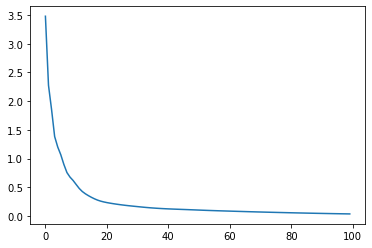

In [63]:
plt.plot(loss_list)